In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from dataloader import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

2024-01-03 18:26:41.952672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 18:26:42.165277: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 18:26:44.841952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-12.2/lib64
2024-01-03 18:26:44.842227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

Le ECL dataset est un dataset sur la consommation d'electricité de 321 clients toutes les heures entre 2012 et 2014.   
Les colonnes représentent les 321 clients et il y a 26 304 lignes. 
 

## Load data

In [2]:
ecl_data = pd.read_csv('electricity.csv', header=None).to_numpy()

In [3]:
# Diviser les données en ensembles de train, test et validation
train_data = ecl_data[:18317]
test_data = ecl_data[18317:18317+2633]
val_data = ecl_data[18317+2633:]

In [4]:
batch_size = 32
scaler = StandardScaler()
scaler.fit(train_data)

train_dataset = MonDataLoaderAllData(ecl_data, 96, 96, scaler=scaler)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

eval_dataset = MonDataLoaderAllData(ecl_data, 96, 96, scaler=scaler)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MonDataLoaderAllData(ecl_data, 96, 96, scaler = scaler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


## Modèle

In [5]:
class Embedding_inverted(nn.Module):
    def __init__(self, T, D):
        super(Embedding_inverted, self).__init__()
        self.emb = nn.Linear(T, D)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = x.permute(0,2,1)
        x_emb = self.emb(x)
        return self.dropout(x_emb)

class FeedForward(nn.Module):
    def __init__(self, N):
        super(FeedForward, self).__init__()
        self.feed_forward = nn.Sequential(
          nn.Conv1d(N, N, kernel_size=1),
          nn.GELU(),
          nn.Dropout(0.1),
          nn.Conv1d(N, N, kernel_size=1), 
        )

    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.feed_forward(x)
        x = x.permute(0,2,1)
        return x
    
class Attention(nn.Module):
    def __init__(self, N, embed_dim):
        super(Attention, self)
        self.query_projection = nn.Linear(N, N)
        self.key_projection = nn.Linear(N, N)
        self.value_projection = nn.Linear(N, N)

    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = 1. / torch.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        A = torch.softmax(scale * scores, dim=-1)
        V = torch.einsum("bhls,bshd->blhd", A, values)
        return V
        

class TrmBlock(nn.Module):
    def __init__(self, N,D):
      super(TrmBlock, self).__init__()

      self.multivariate_attention= nn.MultiheadAttention(D, num_heads=1)
      self.layer_norm1 = nn.LayerNorm(D)
      self.feed_forward = FeedForward(D)
      self.layer_norm2 = nn.LayerNorm(D)

    def forward(self, x):
      att,_ = self.multivariate_attention(x,x,x)
      x = self.layer_norm1(x + att)
      #print("x_norm  : ", x.shape)
      #print("permute : ", xT.shape)
      x_forward = self.feed_forward(x)
      x= self.layer_norm2(x + x_forward)
      return x


class iTransformer(nn.Module):
    def __init__(self, N, T, D, S, num_blocks):
      super(iTransformer, self).__init__()

      self.embedding = Embedding_inverted(T, D)
      self.trmblock = nn.ModuleList([TrmBlock(N, D) for _ in range(num_blocks)])
      self.projection = nn.Linear(D, S, bias=True)


    def forward(self, x):
      #print("x : ",x.shape)
      x = self.embedding(x)
      #print('emb : ',x.shape)
      for block in self.trmblock:
            x = block(x)
      #print('trmblock : ',x.shape)
      y = self.projection(x)
      #print('proj : ', y.shape)
      y=y.permute(0,2,1)
      #print('final : ', y.shape)
      return y

## Train

In [6]:
def MAE(pred, true):
    return np.mean(np.abs(pred - true))

In [7]:
def MSE(pred, true):
    return np.mean((pred - true) ** 2)

In [8]:
def eval(model, val_loader, device, criterion, writer, epoch):
    model.eval()

    epoch_loss = []
    #epoch_accuracy = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.float().to(device), target.float().to(device)
            yhat = model(data)
            loss = criterion(yhat, target)
            
            epoch_loss.append(loss.item())
            #epoch_accuracy.append()

        """
        writer.add_scalar('Loss validation', np.mean(epoch_loss), epoch)
    
        for name, weight in model.named_parameters():
            writer.add_histogram(name, weight, epoch)
            writer.add_histogram(f'{name}.grad', weight.grad, epoch)

        entropie = criterion(logits,target)
        writer.add_histogram('Entropy validation', entropie, epoch)
        
        writer.add_scalar('Accuracy validation', np.mean(epoch_accuracy), epoch)
        """

        return np.mean(epoch_loss)
        

In [9]:
def train(model, optimizer, train_loader, val_loader, nb_epoch, device, writer):
    
    criterion = nn.MSELoss()
    
    loss_values = []
    loss_eval = []


    for epoch in range(nb_epoch):
        print("---------------------")
        print("---- epoch : ", epoch)
        print("---------------------")

        model.train()
        epoch_loss = []

        for i, (data, target) in enumerate(train_loader):
            data, target = data.float().to(device), target.float().to(device)
            optimizer.zero_grad()

            yhat = model(data)
            loss = criterion(yhat, target)
            epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()


        loss_values.append(np.mean(epoch_loss))

        """
        writer.add_scalar('Loss train', np.mean(epoch_loss), epoch)
    
        for name, weight in model.named_parameters():
            writer.add_histogram(f'{name}', weight, epoch)
            writer.add_histogram(f'{name}.grad', weight.grad, epoch)

        entropie = criterion(logits,target)
        writer.add_histogram('Entropy train', entropie, epoch)
        
        writer.add_scalar('Accuracy train', np.mean(epoch_accuracy), epoch)

        """

        epoch_loss_eval = eval(model, val_loader, device, criterion, writer, epoch)
        loss_eval.append(epoch_loss_eval)
        print("loss train :", loss_values[-1])
        print("loss eval :", loss_eval[-1])

        
    return loss_values, loss_eval

## Test

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
writer = SummaryWriter()

cuda


In [11]:
N = 321 #nb variables
T = 96 #input length (lookback window)
D = 256 # ou 512
S = 96 # ou 192, 336, 720
#hidden_dim = 176 #dimension latente dans le feed forward du transformer 
num_blocks = 4 #2 ou 3 ou 4 (nombre de block de transformer)

itransformer = iTransformer(N, T, D, S, num_blocks).to(device)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-3) #10−3, 5 × 10−4, 10−4 



In [12]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device, writer)

---------------------
---- epoch :  0
---------------------
loss train : 0.19504392791984995
loss eval : 0.17577666472345038
---------------------
---- epoch :  1
---------------------
loss train : 0.16823897309573746
loss eval : 0.15954136113497244
---------------------
---- epoch :  2
---------------------
loss train : 0.16108179594012284
loss eval : 0.1536950023635836
---------------------
---- epoch :  3
---------------------
loss train : 0.1569235266063422
loss eval : 0.15310965408599775
---------------------
---- epoch :  4
---------------------
loss train : 0.15366251854875967
loss eval : 0.14995409054027092
---------------------
---- epoch :  5
---------------------
loss train : 0.15159420152774722
loss eval : 0.14484755343926378
---------------------
---- epoch :  6
---------------------
loss train : 0.15099477325135477
loss eval : 0.14590405679219454
---------------------
---- epoch :  7
---------------------
loss train : 0.14909798197181834
loss eval : 0.14459445764817086
--

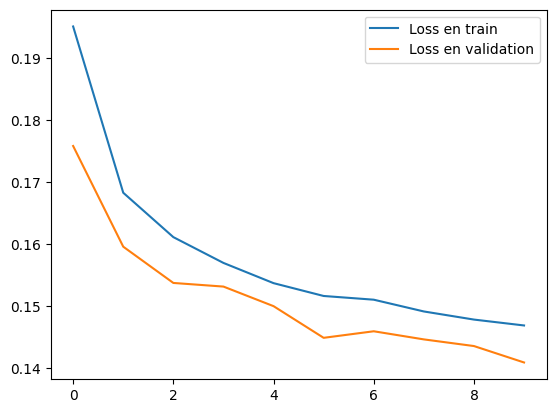

In [13]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

In [14]:
def test(model, test_loader):
    model.eval()
    criterion = nn.MSELoss(reduction='mean')
    loss_batch = []
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.float().to(device), target.float().to(device)
            yhat = model(data)
            loss = criterion(yhat, target)
            loss_batch.append(loss.item())
        """
        if write_tensorboard:

            writer.add_scalar('Loss validation', np.mean(epoch_loss), epoch)
        
            for name, weight in model.named_parameters():
                writer.add_histogram(name, weight, epoch)
                writer.add_histogram(f'{name}.grad', weight.grad, epoch)

            entropie = criterion(logits,target)
            writer.add_histogram('Entropy validation', entropie, epoch)
            
            writer.add_scalar('Accuracy validation', np.mean(epoch_accuracy), epoch)
        """
        
        return np.mean(loss_batch), target, yhat

In [15]:
loss_test, target, yhat = test(itransformer, test_loader )
print("MSE : ", loss_test)

MSE :  0.14092204227363725


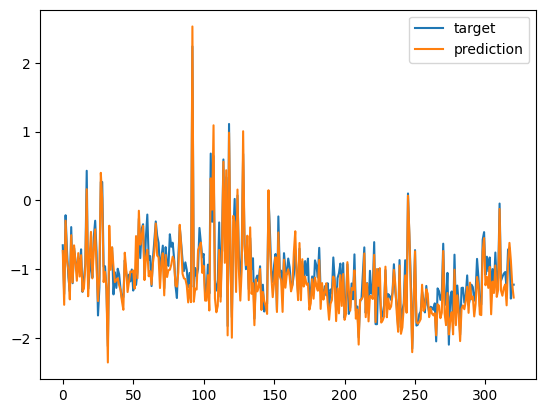

In [16]:
plt.figure()
plt.plot(target[0][:][0].to("cpu"),label="target")
plt.plot(yhat[0][:][0].to("cpu"),label="prediction")
plt.legend()
plt.show()


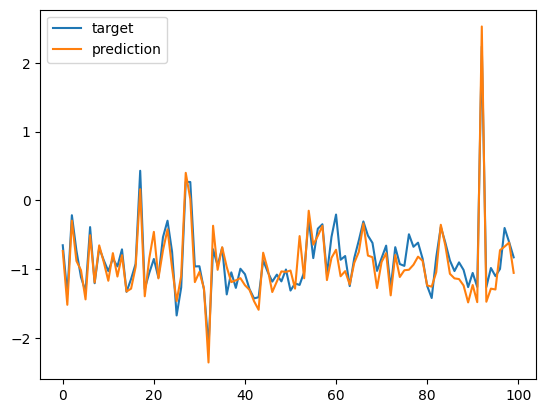

In [23]:
plt.figure()
plt.plot(target[0][:][0][:100].to("cpu"),label="target")
plt.plot(yhat[0][:][0][:100].to("cpu"),label="prediction")
plt.legend()
plt.show()